<div style="text-align: center;"><h1>Clusterização com dataset normalizado </h1> </div>

### Imports e setup

In [1]:
import pandas as pd
import streamlit as st
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.base import TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_samples, silhouette_score

color_scale = ['#00ccff','#cc00ff','#ffcc00','#0066bb','#6600bb','#bb0066','#bb6600','#ff0066','#66ff66','#ee0503']
clustering_cols = ['Smoker', 'HvyAlcoholConsump', 'Fruits', 'Veggies', 'Diabetes_012', 'BMI']

In [2]:
df = pd.read_parquet('../KDD/dfCleaned.parquet', columns=clustering_cols)
df.head()

,Smoker,HvyAlcoholConsump,Fruits,Veggies,Diabetes_012,BMI
0,1.0,0.0,0.0,0.0,0.0,25.0
1,0.0,0.0,1.0,0.0,0.0,28.0
2,0.0,0.0,1.0,1.0,0.0,27.0
3,0.0,0.0,1.0,1.0,0.0,24.0
4,1.0,0.0,1.0,1.0,0.0,25.0


### Gráfico de cotovelo

Realização de um gráfico de cotovelo para melhor visualização do número ideal de clusters no nosso dataset.

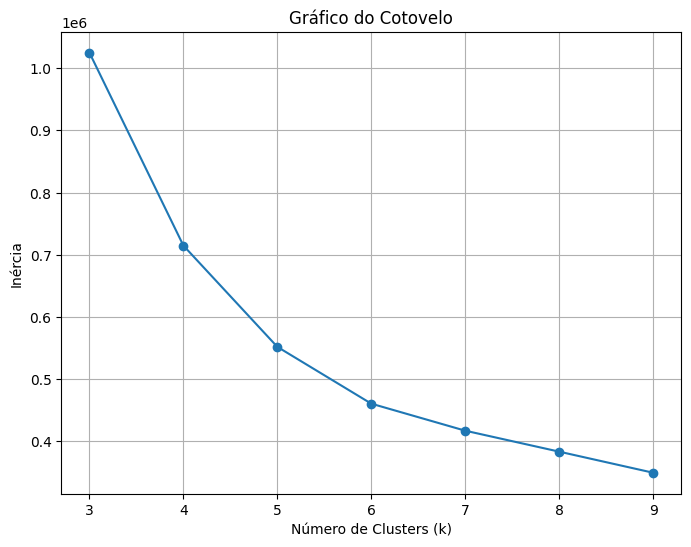

In [3]:
k_range = range(3, 10)
inercia = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10 , random_state=42)
    kmeans.fit(df)
    inercia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, inercia, marker='o')
plt.title('Gráfico do Cotovelo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Número de clusters ideal = 6.

### K-means

In [4]:
n_clusters = 5

def clusterize_kmeans(df: pd.DataFrame) -> pd.Series:
    X = df.values
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=4294967295)
    return kmeans.fit_predict(X)

def plot_cluster_kmeans(df: pd.DataFrame, cluster_col: str, cluster_name: str):
    df[cluster_col] = df[cluster_col].astype(str)
    
    cluster_summary = df.groupby(cluster_col)[clustering_cols].mean()
    
    for c in clustering_cols:
        fig = px.bar(cluster_summary, x=cluster_summary.index, y=c,
                     color=cluster_summary.index, color_discrete_sequence=color_scale,
                     labels={c: f'Média de {c}'})
        fig.show()

### Resultados com K-means

In [5]:
df_kmeans = df.copy()
df_kmeans['cluster'] = clusterize_kmeans(df_kmeans)
plot_cluster_kmeans(df_kmeans, 'cluster', 'Clusters')

d:\UFRPE\PISI3\Diabetes-PISI3\venv\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


d:\UFRPE\PISI3\Diabetes-PISI3\venv\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



d:\UFRPE\PISI3\Diabetes-PISI3\venv\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



d:\UFRPE\PISI3\Diabetes-PISI3\venv\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



d:\UFRPE\PISI3\Diabetes-PISI3\venv\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



d:\UFRPE\PISI3\Diabetes-PISI3\venv\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### Silhouette plot

In [6]:
def plot_silhouette(df: pd.DataFrame, labels: np.ndarray):
    X = df.values
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    y_lower, y_upper = 0, 0
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        y_upper += len(ith_cluster_silhouette_values)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color_scale[i % len(color_scale)],
                         edgecolor=color_scale[i % len(color_scale)],
                         alpha=0.7)
        ax.text(-0.05, (y_lower + y_upper) / 2, str(i), color=color_scale[i % len(color_scale)],
                ha='center', va='center', fontsize=12)
        y_lower += len(ith_cluster_silhouette_values)
    
    ax.set_xlabel('Coeficiente de Silhouette')
    ax.set_ylabel('Cluster')
    ax.axvline(x=silhouette_avg, color='red', linestyle='--')
    ax.set_yticks([])
    ax.set_title('Silhouette Plot')
    plt.show()

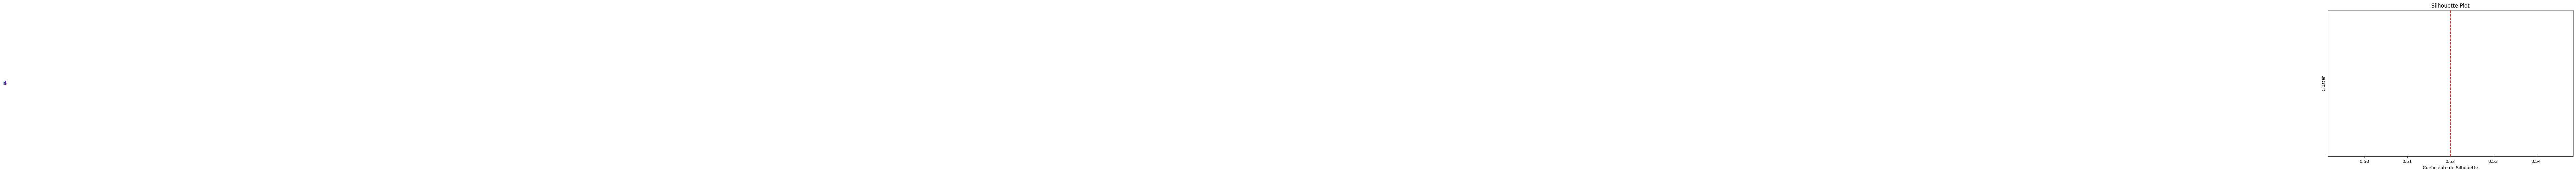

In [7]:
plot_silhouette(df_kmeans, df_kmeans['cluster'].values)